In [1]:
import matplotlib.pyplot as plt

In [3]:
from sklearn import datasets
data = datasets.load_diabetes()

features_in_different_scale = False

if features_in_different_scale:
    data["data"][:, 0] = 100*data["data"][:, 0]
    data["data"][:, 1] = 10*data["data"][:, 1]
    data["data"][:, 2] = 0.01*data["data"][:, 2]
    data["data"][:, 3] = 100000*data["data"][:, 3]


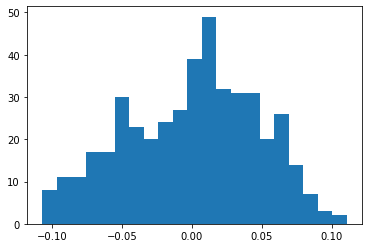

In [4]:
plt.hist(data["data"][:, 0], bins=21);

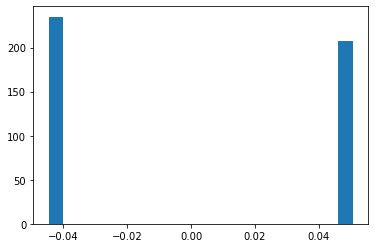

In [5]:
plt.hist(data["data"][:, 1], bins=21);

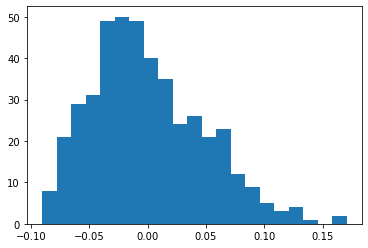

In [6]:
plt.hist(data["data"][:, 2], bins=21);

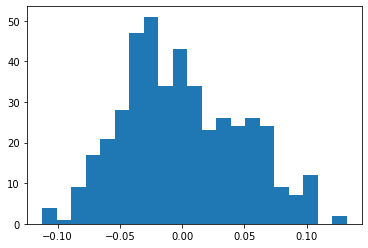

In [7]:
plt.hist(data["data"][:, 3], bins=21);

In [10]:
import torch

# define a floating point model where some layers could be statically quantized
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()
        self.lin1 = torch.nn.Linear(10, 128) #10 input features
        self.relu = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(128, 1) #1 regression output
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

In [11]:
model_fp32 = M()
optimizer = torch.optim.AdamW(model_fp32.parameters(), lr=0.005)
for epoch in range(1000):
    optimizer.zero_grad()
    out = model_fp32(torch.tensor(data["data"]).to(dtype=torch.float))
    loss = torch.nn.functional.mse_loss(out[:, 0], torch.tensor(data["target"]).to(torch.float))
    loss.backward()
    if epoch%100 == 0:
        print(epoch, loss.detach().cpu().item())
    optimizer.step()

0 29113.85546875
100 21004.56640625
200 6500.8671875
300 3638.078125
400 3340.591796875
500 3176.395751953125
600 3077.52490234375
700 3016.8818359375
800 2977.9345703125
900 2951.53173828125


In [12]:
import matplotlib.pyplot as plt

In [13]:
out = model_fp32(torch.tensor(data["data"]).to(torch.float)).detach().cpu().numpy()[:, 0]

(0.0, 400.0)

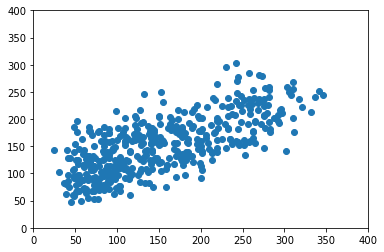

In [14]:
plt.scatter(data["target"], out)
plt.xlim(0,400)
plt.ylim(0,400)

In [15]:
# model must be set to eval mode for static quantization logic to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
#model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.tensor(data["data"]).to(torch.float)
# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
out_quantized = model_int8(input_fp32)[:, 0]

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


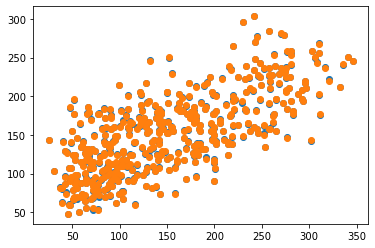

In [16]:
plt.scatter(data["target"], out)
plt.scatter(data["target"], out_quantized)

In [17]:
model_int8.quant

Quantize(scale=tensor([0.0026]), zero_point=tensor([52]), dtype=torch.quint8)

In [18]:
x1 = model_int8.quant(input_fp32)
x1

tensor([[ 0.0371,  0.0503,  0.0609,  ..., -0.0026,  0.0212, -0.0185],
        [-0.0026, -0.0450, -0.0503,  ..., -0.0397, -0.0689, -0.0927],
        [ 0.0848,  0.0503,  0.0450,  ..., -0.0026,  0.0026, -0.0265],
        ...,
        [ 0.0424,  0.0503, -0.0159,  ..., -0.0106, -0.0477,  0.0159],
        [-0.0450, -0.0450,  0.0397,  ...,  0.0265,  0.0450, -0.0265],
        [-0.0450, -0.0450, -0.0742,  ..., -0.0397, -0.0053,  0.0026]],
       size=(442, 10), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0026487470604479313,
       zero_point=52)

In [19]:
model_int8.lin1

QuantizedLinear(in_features=10, out_features=128, scale=0.029241807758808136, zero_point=15, qscheme=torch.per_channel_affine)

In [20]:
x2 = model_int8.lin1(x1)
x2

tensor([[-0.2047,  2.1347,  1.8130,  ..., -0.0585, -0.0877,  2.0762],
        [-0.2339,  0.8773,  0.8188,  ..., -0.0585, -0.1170,  0.8480],
        [-0.2047,  1.9007,  1.5498,  ..., -0.0585, -0.0877,  1.8130],
        ...,
        [-0.2047,  1.5206,  1.1697,  ..., -0.0585, -0.1170,  1.4621],
        [-0.2047,  2.1931,  1.9300,  ..., -0.0877, -0.0877,  2.1347],
        [-0.2339,  0.6433,  0.4386,  ..., -0.0877, -0.1170,  0.5848]],
       size=(442, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.029241807758808136,
       zero_point=15)

In [21]:
x3 = model_int8.relu(x2)
x3

tensor([[0.0000, 2.1347, 1.8130,  ..., 0.0000, 0.0000, 2.0762],
        [0.0000, 0.8773, 0.8188,  ..., 0.0000, 0.0000, 0.8480],
        [0.0000, 1.9007, 1.5498,  ..., 0.0000, 0.0000, 1.8130],
        ...,
        [0.0000, 1.5206, 1.1697,  ..., 0.0000, 0.0000, 1.4621],
        [0.0000, 2.1931, 1.9300,  ..., 0.0000, 0.0000, 2.1347],
        [0.0000, 0.6433, 0.4386,  ..., 0.0000, 0.0000, 0.5848]],
       size=(442, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.029241807758808136,
       zero_point=15)

In [22]:
model_int8.lin2

QuantizedLinear(in_features=128, out_features=1, scale=2.388714551925659, zero_point=0, qscheme=torch.per_channel_affine)

In [23]:
x4 = model_int8.lin2(x3)
x4[:10]

tensor([[191.0972],
        [ 74.0501],
        [164.8213],
        [164.8213],
        [133.7680],
        [100.3260],
        [ 83.6050],
        [126.6019],
        [150.4890],
        [203.0407]], size=(10, 1), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=2.388714551925659,
       zero_point=0)

In [24]:
model_int8.dequant

DeQuantize()

In [25]:
x5 = model_int8.dequant(x4)

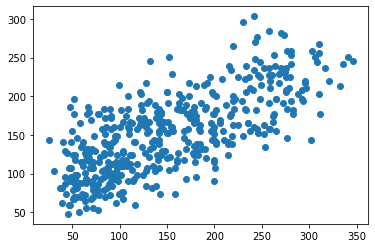

In [26]:
plt.scatter(data["target"], x5[:, 0])